# Assignment 09

## Association Models  

## CSCI E-108

### Steve Elston

## Introduction     

Association models are widely used to find **association rules** between items in **baskets**. A basket is a set of items assocaited with a single event such as a purchase by a customer at the store. The goal is to find rules for **frequent item sets** that associate common items found with high probability in the baskets.  

There are a number of widely used algorithms for finding frequent itemsets. In this notebook you will apply two algorithms, **apriori** and **fp-growth**. To execute the code in this notebook you will need to install the mlxtend package, following [these instructions](https://rasbt.github.io/mlxtend/installation/).    

To get started, execute the code in the cell below to import the packages required for this notebook.   

In [6]:
import pandas as pd  
import numpy as np
from os import path
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

%matplotlib inline

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


## Loading the Dataset

The dataset used here is a derivative of the more complex data used for the [Kaggle Instacrt Market Basket Analysis competition](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data?select=orders.csv.zip) held in 2017. The orginal dataset was much larger and contained files and features we will not use here.     

There are two files from the Kaggle competition files required for this notebook:     
- orders_products_priors.csv contins the orders (baskets) of Intacart orders. This file is over 500 MB.    
- products.csv constins information to map item ids to english lanaguge product descriptions.            

You will need to download these two files from the Kaggle contest site by the following steps:   
1. In you file system, find or create a directory where you will store these files.     
2. Go to the `Data` tab on the Kaggle contest site and download the required files. You will need to sign in to Kaggle to do so.   
3. Set the **relative `PATH` variable** in the code cell below for the path from where you run the notebook to where you have stored the data files.       

In [7]:
PATH=''

### Load the product id files

With the files download you are now ready to import the files into the notebook. The code in the cell below does the following:   
1. Loads the .csv file.    
2. Set the index of the data frame to the product id.
3. Display the head of the data frame.  

In [8]:
product_names = pd.read_csv(path.join(PATH, 'products.csv'))
product_names.set_index('product_id', inplace=True)
product_names.head(10)

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13
6,Dry Nose Oil,11,11
7,Pure Coconut Water With Orange,98,7
8,Cut Russet Potatoes Steam N' Mash,116,1
9,Light Strawberry Blueberry Yogurt,120,16


Only the index, product id, and product name column will be used here.   

### Load the basket dataset

Next execute the code in the cell below to import the large basket dataset.   

In [9]:
baskets_data = pd.read_csv(path.join(PATH, 'order_products__prior.csv'))
print(baskets_data.head(20))

    order_id  product_id  add_to_cart_order  reordered
0          2       33120                  1          1
1          2       28985                  2          1
2          2        9327                  3          0
3          2       45918                  4          1
4          2       30035                  5          0
5          2       17794                  6          1
6          2       40141                  7          1
7          2        1819                  8          1
8          2       43668                  9          0
9          3       33754                  1          1
10         3       24838                  2          1
11         3       17704                  3          1
12         3       21903                  4          1
13         3       17668                  5          1
14         3       46667                  6          1
15         3       17461                  7          1
16         3       32665                  8          1
17        

Examine the data displayed. There are multiple rows for each order id (basket). The product ids are in the second column. The other columns are not used here.   

### Reformat the basket dataset    

Reformatting of the data is required before we can apply the algorithms in the [mlxtend.frequent_patterns](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/) subpackage.   

The data includes over 3 million baskets with 50 thousand possible items. If repersented as a dense array there would be over 150 million values, mostly 0s. Such a representation will consume significant about of memory. Therefore the dataset will be represented by a sparse matrix. The code in the cell below performs the following transformations of the basket data:    
> 1. Transform the data frame into a list of lists. The top level is a list of the baskets, determined by unique order id. The second level lists are the product ids for each unique order.     
> 2. The [mlxtend.preprocessing.transactionencoder](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.preprocessing/#transactionencoder) is apply to the input data frame to create a sparse representation of the products in the baskets. This data structure is then transformed into a [sparse Pandas data frame](https://pandas.pydata.org/docs/user_guide/sparse.html).     
> 3. The column names are set to the product ids.       

Execute the code.  

In [10]:
## Create a list of lists, containing the baskets  
basket_list = baskets_data.loc[:,['order_id', 'product_id']].groupby('order_id')['product_id'].apply(list).tolist()

## 
te = TransactionEncoder()
oht_ary = te.fit(basket_list).transform(basket_list, sparse=True)
sparse_basket_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)

## Add product identifiers as column names for the data frame.   
sparse_basket_df.columns = [str(i) for i in sparse_basket_df.columns]
sparse_basket_df.head(20)

/var/folders/2x/j2yg_98j10n2xd364kzb8nvm0000gn/T/ipykernel_76628/578719965.py:7: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  sparse_basket_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)


,1,2,3,4,5,6,7,8,9,10,...,49679,49680,49681,49682,49683,49684,49685,49686,49687,49688
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The `head()` method displays the 20 rows of the dataframe in a dense format. Notice that all the values displayed are 0s. There are very few products in the baskets.   

## Exploring the Dataset     

Before applying any association rule minning algorithms we will first explore the dataset.    

As a first step, execute the code in the cell below to display a summary of the data characteristics.   

In [11]:
print('Unique number of orders = ' + str(len(baskets_data.order_id.unique())))
print('Unique number of products = ' + str(len(baskets_data.product_id.unique())))
print('Average number of products per order = ' + str(round(baskets_data.shape[0]/len(baskets_data.order_id.unique()), 1)))

Unique number of orders = 3214874
Unique number of products = 49677
Average number of products per order = 10.1


> **Exercise 9-1:** You can see there are more baskets than unique items. Also, the baskets are generally quite small on average. This small number of items per basket is why a spare data frame is an efficient representation of these data. Ignoring overhead, such as hash structures, approximaely how much memory compression does the sparse array achieve as compared to the alternative dense array? Compute the answer in the cell below.      

In [12]:
# Dense array memory usage
dense_memory = baskets_data.order_id.nunique() * baskets_data.product_id.nunique() * 1  # 1 byte per value

# Sparse array memory usage
non_zero_values = oht_ary.count_nonzero()
sparse_memory = non_zero_values * oht_ary.dtype.itemsize  # Size of non-zero values in bytes

# Memory compression ratio
compression_ratio = dense_memory / sparse_memory

print("Memory compression achieved by the sparse array: {:.2f} times".format(compression_ratio))

Memory compression achieved by the sparse array: 4923.93 times


### Support analysis    

You will now create some plots to explore the distribution of the suppot of the items in the baskets. Recall that for a database $D$ contining items in the set $\mathbf{I} = {I_1, I_2,..., I+N }$, the support for item $I_i, Sup_{T}(I_i),$ by rule $T$ is: 

$$Sup_{T}(I_i) = \frac{|\{ I_i \subseteq D\}|}{|D|}$$

The code in the cell below computes the D support of all the products used in the baskets in a descending order of frequency. Some summary statistics are then computed and displayed. Execute this code and examine the results.   

In [13]:
num_baskets = sparse_basket_df.shape[0]
item_frequency = [sparse_basket_df.loc[:,i].sum(axis=0)/num_baskets for i in sparse_basket_df.columns]
item_frequency.sort(reverse=True)

median_support = np.median(item_frequency)
mean_support = np.mean(item_frequency)
print('Mean support = ' + str(round(mean_support, 6)))
print('Median support = ' + str(round(median_support, 7)))

Mean support = 0.000203
Median support = 1.87e-05


Notice that the mean support is a reasonable number, whereas the median support is a much smaller number. This difference between mean and median indicates a skewed distribution where many of the products are rarely ordered.       

The code in the cell below displays the cumulative fequency distribution of item support for the most frequent 200 items in the baskets. A proposed minimum support level is shown by a horizontal red line. Execute this code and examine the result.   

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


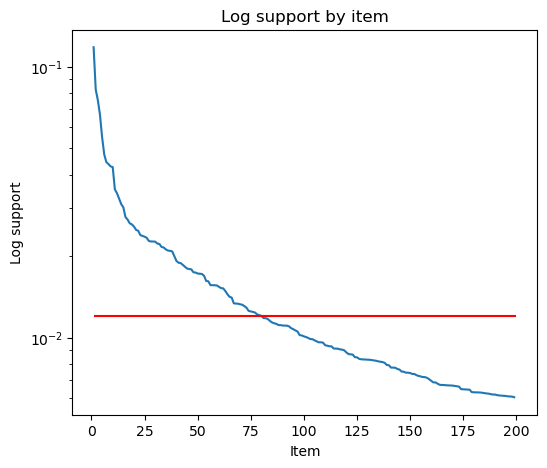

In [14]:
def plot_item_fequency(item_frequency, end_sample, ax, min_support, start_sample=1): 
    ax.plot(list(range(start_sample, end_sample)), item_frequency[start_sample:end_sample])
    ax.hlines(min_support, start_sample, end_sample, color='red')
    ax.set_xlabel('Item')
    ax.set_ylabel('Log support')
    ax.set_title('Log support by item')
    ax.set_yscale('log')


min_support=0.012
end_sample = 200
fig, ax = plt.subplots(figsize=(6,5))
plot_item_fequency(item_frequency, end_sample, ax, min_support)

There appears to be a bit of a break in the above curve around 18. To investigate this point further, execute the code in the cell below to display side by side plots of subsets of the log support values.     

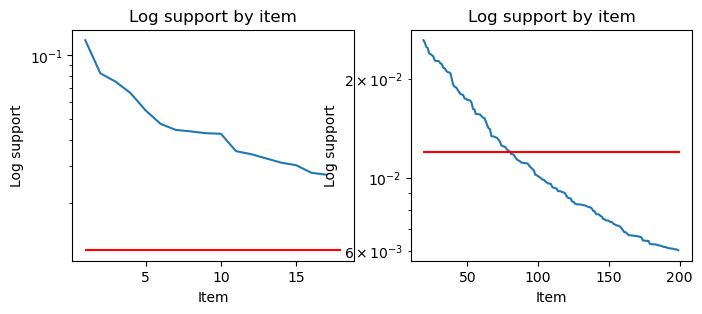

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))

end_sample=18
plot_item_fequency(item_frequency, end_sample, ax[0], min_support)
start_sample=19 
end_sample=200
plot_item_fequency(item_frequency, end_sample, ax[1], min_support, start_sample=start_sample)

> **Exercise 9-2:** The support, and therefore frequency, of the items decline in a super-logarithmic manner. That is, faster than logarithmic. Even for the first 18 items as well as for items 19-200. Describe what this observaqtions means in terms of contents of the baskets.         

> **Answer:**  This suggests a significant variation in the popularity of items in the baskets.

> For the first 18 items, which are likely the most frequent and popular items, the decline in support is particularly steep. This indicates that there are a small number of highly popular items that are commonly purchased together in many baskets. These items are likely essential household products or commonly consumed goods.

> For items 19-200, although the decline in support is still rapid, it may be slightly less steep compared to the first 18 items. This suggests that there is more diversity in the types of products being purchased beyond the most popular items. A few core items with an overall long tail is the case here.

### Frequncy of basket size

Another view on the basket data is the frequency of the number of items in the baskets. A visualizaiton will give an idea of the distribution of the number of items in customers' baskets. 

There is a difficulty with computing the frequency of basket size for the sparse data frame. The number of items in a basket is the sum of along the row of the data frame. However, expanding the entire sparse data frame to do this calculation for all baskets requires and excessive amount of memory. 

A solution to the excessive memory problem is to operate a row at a time. This approach trades lower memoty consumption with less efficient computing. In principle, this operation can be performed with MapRuduce. The approach we adopt here is to use a **representative random sample** of the baskets. 

The code in the cell below randomly (Bernoulli) samples a fraction of $0.005$ or about $16,000$ rows of the sparse data frame. The basket size is computed for each of these sampled rows. Execute the code in the cell below to compute the sample.       

In [36]:
sample_size=int(0.005*sparse_basket_df.shape[0])
index_sample = np.random.choice(list(range(sparse_basket_df.shape[0])), size=sample_size)
print('Size of the sample = ' + str(len(index_sample)))
basket_size_samples = sparse_basket_df.iloc[index_sample,:].sum(axis=1)

Size of the sample = 16074


To display some summary statistics and a histogram of the sample of basket sizes execute the code in the cell below.   

Mean basket size = 10.0
Median basket size = 8.0
Minimum size = 1  Maximum size = 69


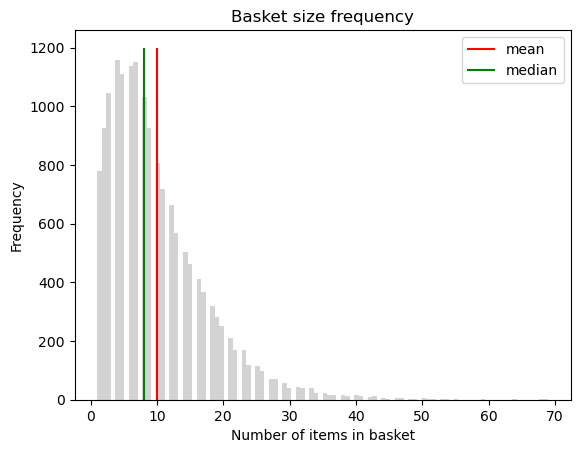

In [37]:
mean_basket = np.mean(basket_size_samples)
median_basket = np.median(basket_size_samples)
print('Mean basket size = ' + str(round(mean_basket, 1)))
print('Median basket size = ' + str(round(median_basket, 1)))
print('Minimum size = ' + str(np.min(basket_size_samples))  + '  Maximum size = ' + str(np.max(basket_size_samples)))

plt.hist(basket_size_samples, bins=100, color='lightgray');
plt.vlines(mean_basket, 0, 1200, color='red', label='mean');
plt.vlines(median_basket, 0, 1200, color='green', label='median');
plt.legend();
plt.xlabel('Number of items in basket');
plt.ylabel('Frequency');
plt.title('Basket size frequency');

Notice the distribution of basket sizes is strongly right skewed. The mode of the basket size distribution is less than the median, which in turn is less than the mean. In other words, most baskets are quite small, as small as a single unique item, and only a few are large, at least 96 unique items. Consequently, one should expect only few association rules to arrise for any reasonable support threshold.   

## Apply the Apriori Algorithm  

You will now apply the [apriori algorithm from the mlxtend package](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/#apriori) to the basket data. The minimum support used in the same as shown in the foregoing plots. To do so, execute the code in the cell below.   

> **Note on speed-memory trade-off:** The implementation of the apriori algorithm in mlextend has an option to work wiht limited memory. This option uses a less compuationally efficient method to manage the creation of the item sets, but which uses considerably less memeory. The `low_memory` argument controls which option is used. Here we set this argument to `True` to help ensure the notebook will not crash out of memory. If you have around 16 MB free RAM in your enviroment, you may wish to set this argument to `False` and see what happens.   

In [38]:
%time item_sets = apriori(sparse_basket_df, min_support=min_support, use_colnames=True, verbose=1, low_memory=True)

Processing 30 combinations | Sampling itemset size 2
CPU times: user 2.36 s, sys: 756 ms, total: 3.12 s
Wall time: 3.25 s


To display the items and itemsets, the english lanugage names need to be joined with the product ids in the support table. The code in the cell below expands the item set tuples using the product ids to create a data frame with support and item set names as the columns. Execute the code to display the result. 

In [39]:
def display_item_sets(set, product_names): 
    prod_list = product_names.product_name
    named_sets =[]
    for item in set.itemsets: 
        named_sets.append([prod_list[int(id)] for id in list(item)])
    return pd.DataFrame({'support':set.support,
                         'itemsets':named_sets}).sort_values('support', ascending=False).reset_index()

pd.set_option('display.max_rows', None)
named_item_sets = display_item_sets(item_sets, product_names)        
named_item_sets

,index,support,itemsets
0,32,0.146993,[Banana]
1,15,0.118030,[Bag of Organic Bananas]
2,23,0.082331,[Organic Strawberries]
3,25,0.075251,[Organic Baby Spinach]
4,75,0.066436,[Organic Hass Avocado]
5,77,0.054999,[Organic Avocado]
6,76,0.047485,[Large Lemon]
7,17,0.044466,[Strawberries]
8,35,0.043743,[Limes]
9,41,0.042896,[Organic Whole Milk]


The frequent item sets need to be transformed into the corresponding association rules. The rules can create the item sets by permuting which items are the antecedents and consequents. Execute the code in the cell below to display the derived rules.    

In [40]:
association_rules(named_item_sets, min_threshold=min_support)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Hass Avocado),(Bag of Organic Bananas),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
1,(Bag of Organic Bananas),(Organic Hass Avocado),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
2,(Organic Strawberries),(Bag of Organic Bananas),0.082331,0.118030,0.019170,0.232837,1.972702,0.009452,1.149652,0.537319
3,(Bag of Organic Bananas),(Organic Strawberries),0.118030,0.082331,0.019170,0.162414,1.972702,0.009452,1.095612,0.559067
4,(Banana),(Organic Strawberries),0.146993,0.082331,0.017468,0.118832,1.443353,0.005365,1.041424,0.360101
5,(Organic Strawberries),(Banana),0.082331,0.146993,0.017468,0.212163,1.443353,0.005365,1.082720,0.334727
6,(Organic Avocado),(Banana),0.054999,0.146993,0.016609,0.301982,2.054395,0.008524,1.222042,0.543109
7,(Banana),(Organic Avocado),0.146993,0.054999,0.016609,0.112990,2.054395,0.008524,1.065378,0.601682
8,(Organic Baby Spinach),(Banana),0.075251,0.146993,0.015987,0.212445,1.445272,0.004925,1.083108,0.333159
9,(Banana),(Organic Baby Spinach),0.146993,0.075251,0.015987,0.108758,1.445272,0.004925,1.037596,0.361180


> **Exercise 9-3:** Examine the list of items and item sets displayed above. Discribe how the downward closer property of sets relates the antecedents, and the consequents?    

> **Answer:**     If an item is frequent, all possible pairs containing this item are then considered for frequency. For example, if Banana is frequent, pairs like (Banana, Organic Avocado) and (Banana, Organic Baby Spinach) are evaluated next, and this ensures computational efficiency. Once frequent itemsets are identified, rules are generated by dividing these itemsets into antecedents and consequents. For instance:

>(Bag of Organic Bananas) → (Organic Hass Avocado) and 
>(Organic Hass Avocado) → (Bag of Organic Bananas)
Both antecedents and consequents in these rules are subsets of the original frequent itemset. If the original itemset is frequent, its subsets (antecedents and consequents) are guaranteed to be frequent as well.

## The FP-Growth Algorithm  

You will now apply the [fp-growth algorithm from the mlxtend package](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/#fpgrowth) to the basket data. The same support threshold is used as before. Execute the code in the cell below to apply the fp-growth algorithm.      

In [41]:
%time fp_item_sets = fpgrowth(sparse_basket_df, min_support=min_support, use_colnames=True, verbose=1)

81 itemset(s) from tree conditioned on items ()
0 itemset(s) from tree conditioned on items (17794)
0 itemset(s) from tree conditioned on items (28985)
2 itemset(s) from tree conditioned on items (21903)
0 itemset(s) from tree conditioned on items (21903, 24852)
0 itemset(s) from tree conditioned on items (21903, 13176)
0 itemset(s) from tree conditioned on items (46667)
0 itemset(s) from tree conditioned on items (24838)
0 itemset(s) from tree conditioned on items (13176)
2 itemset(s) from tree conditioned on items (47209)
0 itemset(s) from tree conditioned on items (47209, 13176)
0 itemset(s) from tree conditioned on items (47209, 21137)
1 itemset(s) from tree conditioned on items (27966)
0 itemset(s) from tree conditioned on items (31506)
0 itemset(s) from tree conditioned on items (24852)
2 itemset(s) from tree conditioned on items (21137)
0 itemset(s) from tree conditioned on items (21137, 24852)
0 itemset(s) from tree conditioned on items (21137, 13176)
1 itemset(s) from tree con

Examine the verbose outout from the model code. The fp-growth algorithm iterates though all the items with sufficient support. Notice that in 6 cases itemsets with two item consequents are found from an antecedent. These antecedents are then followed by the rules found.         

To see the item sets with sufficient support found by the fp-growth algorthm execute the code in the cell below.

In [42]:
fp_named_item_sets = display_item_sets(fp_item_sets, product_names)        
fp_named_item_sets

,index,support,itemsets
0,9,0.146993,[Banana]
1,5,0.118030,[Bag of Organic Bananas]
2,10,0.082331,[Organic Strawberries]
3,2,0.075251,[Organic Baby Spinach]
4,6,0.066436,[Organic Hass Avocado]
5,11,0.054999,[Organic Avocado]
6,28,0.047485,[Large Lemon]
7,39,0.044466,[Strawberries]
8,50,0.043743,[Limes]
9,16,0.042896,[Organic Whole Milk]


To display the association rule set found by the fp-growth algorthm execute the code in the cell below.    

In [43]:
association_results = association_rules(fp_named_item_sets, min_threshold=min_support)
association_results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Hass Avocado),(Bag of Organic Bananas),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
1,(Bag of Organic Bananas),(Organic Hass Avocado),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
2,(Organic Strawberries),(Bag of Organic Bananas),0.082331,0.118030,0.019170,0.232837,1.972702,0.009452,1.149652,0.537319
3,(Bag of Organic Bananas),(Organic Strawberries),0.118030,0.082331,0.019170,0.162414,1.972702,0.009452,1.095612,0.559067
4,(Banana),(Organic Strawberries),0.146993,0.082331,0.017468,0.118832,1.443353,0.005365,1.041424,0.360101
5,(Organic Strawberries),(Banana),0.082331,0.146993,0.017468,0.212163,1.443353,0.005365,1.082720,0.334727
6,(Organic Avocado),(Banana),0.054999,0.146993,0.016609,0.301982,2.054395,0.008524,1.222042,0.543109
7,(Banana),(Organic Avocado),0.146993,0.054999,0.016609,0.112990,2.054395,0.008524,1.065378,0.601682
8,(Organic Baby Spinach),(Banana),0.075251,0.146993,0.015987,0.212445,1.445272,0.004925,1.083108,0.333159
9,(Banana),(Organic Baby Spinach),0.146993,0.075251,0.015987,0.108758,1.445272,0.004925,1.037596,0.361180


> **Exercise 9-4:** Compare the item set list and the association rules found with the fp-growth algorithm with those found using the apriori algorithm. How can you explain the similarity in terms of the support criteria used by both algorithms?         

> **Answer:**   Both algorithms use the same support threshold (min_support) and the underlying data characteristics do not change between the two algorithms. The FP-Growth and Apriori algorithms, when applied to the same dataset with the same support threshold, yield very similar results in terms of frequent itemsets and association rules. Differences may lie primarily in the efficiency and approach to finding these itemsets, not in the results. 

## Evaluation of Results  

THe final question to address how can one understand and apply these association rules. To do so, it is necessary to consider multiple evaluation metrics. As you have seen, association rules are minned using support as the metric. However, when faced with large sets of association rules it is necssary to filter the set to the most effective or important rules. Any of the evaluation metrics can be used as filtering criteria, including:    
- Lift     
- Confidence     
- Conviction     
- Leverage    

Multiple filtering criteria are often applied to large association rule sets.     

> **Important note:** When sorting by performance metric, order matters. For example, sorting by lift first and then conviction is not the same as sorting by conviction first and then lift. 

> **Exercise 9-5:** To understand these results, start by sorting and displaying the `association_results` table produced with the fp-growth algorithm. To do so, perform a nested sort on the first on then `lift` and then the `conviction` columns in descending order using the [pandas.DataFrame.sort_values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) method. Apply [pandas.DataFrame.reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) to the sorted result.  

In [46]:
# Assuming association_results is a DataFrame containing the association rules
sorted_association_results = association_results.sort_values(by=['lift', 'conviction'], ascending=[False, False])
sorted_association_results = sorted_association_results.reset_index(drop=True)
sorted_association_results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Raspberries),(Bag of Organic Bananas),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
1,(Bag of Organic Bananas),(Organic Raspberries),0.118030,0.042632,0.012599,0.106741,2.503775,0.007567,1.071770,0.680979
2,(Bag of Organic Bananas),(Organic Hass Avocado),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
4,(Organic Hass Avocado),(Organic Strawberries),0.066436,0.082331,0.012689,0.190997,2.319880,0.007219,1.134322,0.609431
5,(Organic Strawberries),(Organic Hass Avocado),0.082331,0.066436,0.012689,0.154124,2.319880,0.007219,1.103665,0.619987
6,(Organic Avocado),(Banana),0.054999,0.146993,0.016609,0.301982,2.054395,0.008524,1.222042,0.543109
7,(Banana),(Organic Avocado),0.146993,0.054999,0.016609,0.112990,2.054395,0.008524,1.065378,0.601682
8,(Organic Strawberries),(Bag of Organic Bananas),0.082331,0.118030,0.019170,0.232837,1.972702,0.009452,1.149652,0.537319
9,(Bag of Organic Bananas),(Organic Strawberries),0.118030,0.082331,0.019170,0.162414,1.972702,0.009452,1.095612,0.559067


> Examine the resulting table and answer these quentstions:   
> 1. Notice that the first two rows of the sorted table have essentially the same support, lift and leverage, and yet have very different values of conviction. How can you explain these results in terms of the values of antecedent support and consequent support?        
> 2. For the grocer, will it be more effective to offer an incentive to buy a bag of organic bannanas to purchasers of organic raspberries or vice versa and why?

> **Answers:**    
> 1.  Conviction is higher when the antecedent is Organic Raspberries and the consequent is Bag of Organic Bananas compared to the reverse. For example, When antecedent is Organic Raspberries, its support is 0.042632, and the consequent (Bag of Organic Bananas) has a higher support of 0.118030. When the antecedent and consequent is flipped, support values are also flipped. Conviction increases when the consequent is less likely to occur independently of the antecedent. Since Organic Raspberries has a lower support, it results in a higher conviction value when it is the consequent.    

> 2.  It will be more effective to offer an incentive to buy a Bag of Organic Bananas to purchasers of Organic Raspberries. This is because of higher Confidence: The rule (Organic Raspberries) → (Bag of Organic Bananas) has a higher confidence (0.295519), meaning customers who buy Organic Raspberries are more likely to also buy a Bag of Organic Bananas. This rule also has a higher conviction (1.251944), indicating that this association is more reliable and customers who buy Organic Raspberries are less likely to buy a Bag of Organic Bananas by chance. Lift and support are equal and thus not considered.

> **Exercise 9-6:** You will now filter the sorted association rule set. In this case you will use several filter criteria to find the most effective association rules. You can perform this task with one line of code by appling the following filter criteria to the association rule dataframe. The filter criteria are intended to find rules that are significnatly better than random guessing. Now, apply these three filters to the sorted association rule data frame:    
> 1. $lift >= 2.0$    
> 2. $conviction >= 1.1$   
> 3. $leverage <= 0.01$

In [47]:
# Apply the filters to the sorted_association_results DataFrame
filtered_association_results = sorted_association_results[
    (sorted_association_results['lift'] >= 2.0) & 
    (sorted_association_results['conviction'] >= 1.1) & 
    (sorted_association_results['leverage'] <= 0.01)
]

filtered_association_results


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Raspberries),(Bag of Organic Bananas),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
4,(Organic Hass Avocado),(Organic Strawberries),0.066436,0.082331,0.012689,0.190997,2.319880,0.007219,1.134322,0.609431
5,(Organic Strawberries),(Organic Hass Avocado),0.082331,0.066436,0.012689,0.154124,2.319880,0.007219,1.103665,0.619987
6,(Organic Avocado),(Banana),0.054999,0.146993,0.016609,0.301982,2.054395,0.008524,1.222042,0.543109


> Examine these results and answer the following questions:  
> 1. Notice that the last rule has the highest support and confidence, but yet has the lowest lift. How can you explain this situation in terms of the other metrics?        
> 2. The first three rules all have identical support and nearly the same leverage. Which metrics differentiate these rules and why?    

> **Answers:**   

> 1. The last rule has the highest support and confidence because Banana is a relatively common item, and Organic Avocado appears frequently with it. The lift is lower because Banana has a high consequent support (0.146993), meaning it's common in transactions overall. Thus, while Organic Avocado increases the likelihood of purchasing Banana, the increase is less pronounced relative to other item pairs with lower overall frequencies.      

> 2. Confidence indicates the reliability of the rule and differentiates the rules. The first rule has a higher confidence, meaning that Bag of Organic Bananas is more likely to occur with Organic Raspberries than the other consequents with their respective antecedents.
Conviction also differentiates these rules by reflecting the extent to which the presence of the antecedent increases the likelihood of the consequent. The first rule's higher conviction suggests it has better predictive power than the other two rules.    

#### Copyright 2023, Stephen F Elston. All rights reserved.  